<a href="https://colab.research.google.com/github/susiejojo/Summer_school_stuff/blob/master/transforms_DLT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sample_data.load_points as lp

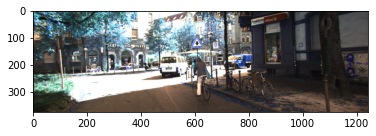

In [0]:
img = cv.imread('sample_data/image.png', cv.IMREAD_UNCHANGED)
plt.imshow(img)

In [0]:
with open('sample_data/K.pkl', 'rb') as fin :
  K = pickle.load(fin)

In [0]:
points = lp.load_velodyne_points('sample_data/lidar-points.bin')
print (points.shape)

(6965, 3)


In [0]:
X0 = np.array([[0.27, 0.06, -0.08]]).T
X0

array([[ 0.27],
       [ 0.06],
       [-0.08]])

In [0]:
K #c must be 721.5377 & x_H and Y_H are the last column values

array([[721.5377,   0.    , 609.5593],
       [  0.    , 721.5377, 172.854 ],
       [  0.    ,   0.    ,   1.    ]])

In [0]:
R_21 = np.array([[0,0,1],[-1,0,0],[0,-1,0]]).T
R_21

array([[ 0, -1,  0],
       [ 0,  0, -1],
       [ 1,  0,  0]])

In [0]:
A = np.identity(3)
J = np.concatenate((A,-X0),axis=1)
J

array([[ 1.  ,  0.  ,  0.  , -0.27],
       [ 0.  ,  1.  ,  0.  , -0.06],
       [ 0.  ,  0.  ,  1.  ,  0.08]])

In [0]:
P = np.matmul(R_21,J)

In [0]:
P_f = np.matmul(K,P)

In [0]:
points.shape

(6965, 3)

In [0]:
b = np.ones(((points.shape)[0],1))
p = np.append(points,b,axis=1)
p.shape

(6965, 4)

In [0]:
proj = np.matmul(P_f,p.T)
projected_image= proj.T

In [0]:
projected_image.shape

(6965, 3)

In [0]:
proj_x = projected_image[:,0]/projected_image[:,2]
proj_y = projected_image[:,1]/projected_image[:,2]

In [0]:
img.shape

(375, 1242, 3)

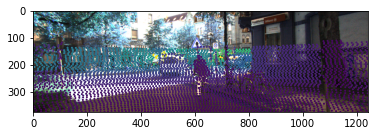

In [0]:
plt.imshow(img)
plt.scatter(proj_x,proj_y,s=1,c=p[:,0]) #since depth in camera coordinate is z, which is x for world
plt.ylim((img.shape[0],0))
plt.xlim((0,img.shape[1]))
plt.show()

In [0]:
P_f

array([[ 6.09559300e+02, -7.21537700e+02,  0.00000000e+00,
        -1.21288749e+02],
       [ 1.72854000e+02,  0.00000000e+00, -7.21537700e+02,
        -1.04393596e+02],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -2.70000000e-01]])

In [0]:
proj_x.shape[0]

6965

In [0]:
def dlt(L,proj_x,proj_y,p):
  M = []
  for i in (L):
    xi = proj_x[i]
    yi = proj_y[i]
    x, y, z = points[i, 0], points[i, 1], points[i, 2]
    M.append([x,y,z,1,0,0,0,0,-xi*x,-xi*y,-xi*z,-xi])
    M.append([0,0,0,0,x,y,z,1,-yi*x,-yi*y,-yi*z,-yi])
    # print (ax.shape)
    # print (ay.shape)
    # print (ax)
    # print (ay)
    
    #np.append(M,ay,axis=0)
  #print (M)
  M = np.asarray(M)
  u,s,v = np.linalg.svd(M)
  P_est = (v[-1,:]/v[-1,-1]).reshape((3,4))
  return P_est

In [0]:
L = np.random.randint(0,points.shape[0]-1,size=20)
P_est = dlt(L,proj_x,proj_y,p)
print (P_est)

[[-2.25762704e+03  2.67236185e+03  1.29924520e-09  4.49217589e+02]
 [-6.40200000e+02 -1.06599296e-11  2.67236185e+03  3.86642948e+02]
 [-3.70370370e+00 -2.49127439e-13 -6.22818597e-14  1.00000000e+00]]


In [0]:
h = P_est[:,-1].T
H = P_est[:,0:3]
print (h)
print (H)
X0t = -np.matmul(np.linalg.inv(H),h)

[449.21758889 386.64294815   1.        ]
[[-2.25762704e+03  2.67236185e+03  1.29924520e-09]
 [-6.40200000e+02 -1.06599296e-11  2.67236185e+03]
 [-3.70370370e+00 -2.49127439e-13 -6.22818597e-14]]


In [0]:
X0t #wow exactly same!!! :)

array([ 0.27,  0.06, -0.08])

In [0]:
q,r = np.linalg.qr(np.linalg.inv(H))

In [0]:
R_est = q.T
K_est = np.linalg.inv(r)
K_est = K_est/K_est[-1,-1]
R_zp = np.array([[-1, 0, 0],[0,-1,0],[0,0,1]]) #to account for -ve camera constant
K_est = np.matmul(K_est,R_zp)
R_est = np.matmul(R_zp,R_est)
print("estimated K: ",K_est)
print("estimated R: ",R_est)

estimated K:  [[7.21537700e+02 3.69723982e-10 6.09559300e+02]
 [0.00000000e+00 7.21537700e+02 1.72854000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
estimated R:  [[ 6.70574707e-14 -1.00000000e+00  1.20569055e-14]
 [ 1.69418868e-14 -1.20569055e-14 -1.00000000e+00]
 [ 1.00000000e+00  6.69464484e-14  1.68308645e-14]]


In [0]:
print (K)
print (R_21)

[[721.5377   0.     609.5593]
 [  0.     721.5377 172.854 ]
 [  0.       0.       1.    ]]
[[ 0 -1  0]
 [ 0  0 -1]
 [ 1  0  0]]


In [0]:
threshold_distance=0.8
threshold_inliers=0
ransac_iters=1000
L = np.random.randint(0,points.shape[0]-1,size=20)
for it in range(ransac_iters):
  L = np.random.randint(0,points.shape[0]-1,size=20)
  P_e = dlt(L,proj_x,proj_y,p)
  #print (P_e)
  src_pts = np.array([p[i] for i in L])
  est_pts = np.matmul(P_e,src_pts.T).T
  dst_pts = np.array([projected_image[i] for i in L])
    # src_pts = np.asarray([points[i] for i in L])
  # print ("src:",src_pts)
  # print ("est:",est_pts)
  # print ("dst:",dst_pts)
  err = (dst_pts - est_pts)/est_pts[-1]
  error = np.sqrt(np.sum(np.square(err), axis=1))
  #print (error)
  #print (np.count_nonzero(error<threshold_distance))
  if (np.count_nonzero(error < threshold_distance))/8 > threshold_inliers:
    #print (it)
    src_inliers = src_pts
    dst_inliers = dst_pts
    best_L = L
    threshold_inliers = (np.count_nonzero(error < threshold_distance))/8
    print (it,threshold_inliers)
  else:
    continue
P_best = dlt(L,proj_x,proj_y,p)
print (P_best)

2 0.25
31 1.0
54 1.5
67 1.75
78 1.875
352 2.375
[[-2.25762704e+03  2.67236185e+03  1.12599024e-09  4.49217589e+02]
 [-6.40200000e+02 -5.41185569e-11  2.67236185e+03  3.86642948e+02]
 [-3.70370370e+00 -1.24563719e-13  4.28187786e-14  1.00000000e+00]]


In [0]:
h_best = P_best[:,-1].T
H_best = P_best[:,0:3]
X0t_best = -np.matmul(np.linalg.inv(H_best),h_best)
q_best,r_best = np.linalg.qr(np.linalg.inv(H_best))
R_best = q_best.T
K_best = np.linalg.inv(r_best)
K_best = K_best/K_best[-1,-1]
R_zp = np.array([[-1, 0, 0],[0,-1,0],[0,0,1]])
K_best = np.matmul(K_best,R_zp)
R_best = np.matmul(R_zp,R_best)
print("estimated K: ",K_best)
print("estimated R: ",R_best)
print("estimated XO: ",X0t_best)

estimated K:  [[7.21537700e+02 2.88075937e-10 6.09559300e+02]
 [0.00000000e+00 7.21537700e+02 1.72854000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
estimated R:  [[ 3.35287353e-14 -1.00000000e+00 -1.22279170e-14]
 [-1.15617832e-14  1.22279170e-14 -1.00000000e+00]
 [ 1.00000000e+00  3.34177130e-14 -1.16728055e-14]]
estimated XO:  [ 0.27  0.06 -0.08]


In [0]:
print (K)
print (R_21)
print (X0)

[[721.5377   0.     609.5593]
 [  0.     721.5377 172.854 ]
 [  0.       0.       1.    ]]
[[ 0 -1  0]
 [ 0  0 -1]
 [ 1  0  0]]
[[ 0.27]
 [ 0.06]
 [-0.08]]
